##### Arquitectura Naive v0

- In this noteook a [naive](https://www.marktechpost.com/2024/04/01/evolution-of-rags-naive-rag-advanced-rag-and-modular-rag-architectures/) type architecture is proposed. It consists of a retrival that integrates the output of the Vector Store, the prompt with the query structure, the queries, the processing, the search of the meaning in the storage vector and the delivery and finally parses the output data to give an answer.

- The objective of this notebook is to review from the data ingestion and chunking process, through how to manage the data in a vector store and query it, how to interact with a basic prompt and how to test the model and its overall performance.

- ![alt text](../sagemaker_documentation/images/Naive_arch.png)

In [28]:
import os
import sys
from dotenv import load_dotenv
sys.path.append('C:/Users/user/Documents/LOKA_Test/LOKA_TECNICAL_TEST_V0/test')

import pandas as pd

from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import UnstructuredMarkdownLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    answer_similarity,
    answer_correctness,
    context_precision,
    context_recall,
    faithfulness,
    context_entity_recall
)


In [9]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [10]:
DIR_PATH = "C:/Users/user/Documents/LOKA_Test/LOKA_TECNICAL_TEST_V0/sagemaker_documentation/sagemaker_documentation"
CHUNK_SIZE_SPLIT = 500
CHUNK_OVERLAP = 100
LLM_MODEL = "gpt-3.5-turbo"
# LLM_MODEL = "llama2"
TEMPERATURE = 0

In [11]:
# Load documents
loader = DirectoryLoader(
    DIR_PATH, glob="*.md", loader_cls=UnstructuredMarkdownLoader
)
docs = loader.load()

In [12]:
# Split
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE_SPLIT, 
    chunk_overlap=CHUNK_OVERLAP
)
splits = text_splitter.split_documents(docs)

# RAGAS expects a file_name dict as key
for document in splits:
    document.metadata['file_name'] = document.metadata['source']

In [13]:
print(len(splits), "chunks de 340 documents")

2907 chunks de 340 documentos


In [14]:
# Model decision:
if LLM_MODEL.startswith("gpt"):
    model = ChatOpenAI(api_key=OPENAI_API_KEY, model= LLM_MODEL, temperature=TEMPERATURE)
    embeddings = OpenAIEmbeddings()
else:
    model = Ollama(model=LLM_MODEL, temperature=TEMPERATURE)
    embeddings = OllamaEmbeddings()

In [15]:
# Embed and create retriever
vectorstore = Chroma.from_documents(
    documents=splits, 
    embedding=embeddings
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [16]:
prompt_rag_template = """
You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. **do not cite extra resources**

Question: {question}

Context: {context} 

Answer:
"""

prompt = PromptTemplate.from_template(prompt_rag_template)

In [18]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [19]:
# LLM
llm = model

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [20]:
# Question
rag_chain.invoke("Whe sage maker create a model what happen?")

'When a SageMaker creates a model, the resulting model artifacts are available in the ModelArtifacts field. This can be done by running a training job in SageMaker or training a machine learning algorithm outside of SageMaker. The model container can be developed using your own inference code.'

In [21]:
rag_chain.invoke("summarize aws-resource-sagemaker-space")

'Amazon SageMaker Spark is a service provided by AWS for machine learning tasks. It allows users to easily build, train, and deploy machine learning models using Spark. SageMaker Spark simplifies the process of integrating Spark with SageMaker for scalable and efficient machine learning workflows.'

#### Evaluation

###### Ragas wants ['question', 'answer', 'contexts', 'ground_truths'] as


- "question": [], <-- question from faq doc
- "answer": [], <-- answer from generated result
- "contexts": [], <-- context
- "ground_truths": [] <-- actual answer


In [22]:
questions = [
    "What is SageMaker?", 
    "What are all AWS regions where SageMaker is available?",
    "How to check if an endpoint is KMS encrypted?",
    "What are SageMaker Geospatial capabilities?",
    "What is Amazon SageMaker?",
    "How does SageMaker handle model training scalability?",
    "Can SageMaker integrate with other AWS services?",
    "What are SageMaker notebooks?",
    "How does SageMaker ensure model security?",
    "What is SageMaker Autopilot?",
    "How does model monitoring work in SageMaker?",
    "What types of machine learning models can SageMaker deploy?",
    "How does SageMaker optimize model performance?",
    "Can SageMaker process real-time data for predictions?"
] #TODO: Get to a YAML or into Tecnical_test_RAG_LOKA_2024/src/config.py

ground_truths = [
    ["SageMaker is a comprehensive AWS service that enables developers and data scientists to quickly build, train, and deploy machine learning models in the cloud."],
    ["AWS regions where SageMaker is available include North America, Europe, Asia Pacific, South America, and the Middle East."],
    ["To verify if an endpoint is encrypted with KMS, review the endpoints IAM policies and configurations in the AWS console or using the AWS CLI."],
    ["SageMakers geospatial capabilities allow you to integrate and analyze location data to improve machine learning models, applicable in areas such as logistics and environmental analysis."],
    ["Amazon SageMaker is a fully managed service that provides every developer and data scientist with the ability to build, train, and deploy machine learning models quickly."],
    ["SageMaker automatically scales the training jobs by adjusting the number of instances based on the workload, ensuring efficient use of resources."],
    ["Yes, SageMaker integrates seamlessly with AWS services like S3 for data storage, IAM for security, and Lambda for serverless computing, enhancing its capabilities."],
    ["SageMaker notebooks are Jupyter notebooks hosted on SageMaker, enabling data scientists to prepare and process data, visualize results, and experiment with models directly."],
    ["SageMaker uses AWS IAM to control access, encrypts data at rest using KMS, and data in transit using SSL to ensure secure model training and deployment."],
    ["SageMaker Autopilot is an automated machine learning (AutoML) service that automatically creates, trains, and tunes the best machine learning models based on the data provided."],
    ["SageMaker Model Monitor continuously tracks the models performance in production, detecting deviations in model quality to provide alerts and insights."],
    ["SageMaker supports all common machine learning models, including linear regression, classification, and deep learning models like CNNs and RNNs."],
    ["SageMaker optimizes models by using hyperparameter tuning to automatically find the best version of a model based on the defined criteria and metrics."],
    ["Yes, SageMaker offers real-time prediction capabilities through endpoints that are scalable and can process thousands of requests per second."]
] #TODO: Get to a YAML or into Tecnical_test_RAG_LOKA_2024/src/config.py


In [23]:
# Compare the responsives 

answers = []
contexts = []

# Inference
for query in questions:
    answers.append(rag_chain.invoke(query))
    contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])

# To dict
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

In [24]:
# Calculate metrics 
result = evaluate(
    dataset = dataset, 
    metrics=[
        answer_relevancy,
        answer_similarity,
        answer_correctness,
        context_precision,
        context_recall,
        faithfulness,
        context_entity_recall
    ],
)

result

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating: 100%|██████████| 98/98 [00:58<00:00,  1.68it/s]


{'answer_relevancy': 0.9108, 'answer_similarity': 0.9196, 'answer_correctness': 0.6609, 'context_precision': 0.7143, 'context_recall': 0.8393, 'faithfulness': 0.9744, 'context_entity_recall': 0.2269}

In [25]:
pd.set_option("display.max_colwidth", None)

df = result.to_pandas()
df

,question,answer,contexts,ground_truths,ground_truth,answer_relevancy,answer_similarity,answer_correctness,context_precision,context_recall,faithfulness,context_entity_recall
0,What is SageMaker?,"SageMaker is a fully managed machine learning service by Amazon. It allows data scientists and developers to build, train, and deploy machine learning models easily. SageMaker includes an integrated Jupyter authoring notebook for data exploration and analysis without the need to manage servers.","[How Amazon SageMaker uses AWS Secrets Manager\n\nSageMaker is a fully managed machine learning service. With SageMaker, data scientists and developers can quickly and easily build and train machine learning models, and then directly deploy them into a production-ready hosted environment. It provides an integrated Jupyter authoring notebook instance for easy access to your data sources for exploration and analysis, so you don't have to manage servers.]","[SageMaker is a comprehensive AWS service that enables developers and data scientists to quickly build, train, and deploy machine learning models in the cloud.]","SageMaker is a comprehensive AWS service that enables developers and data scientists to quickly build, train, and deploy machine learning models in the cloud.",1.000000,0.964816,0.884061,1.0,1.00,1.000000,0.666667
1,What are all AWS regions where SageMaker is available?,I don't know.,[Buy and Sell Amazon SageMaker Algorithms and Models in AWS Marketplace],"[AWS regions where SageMaker is available include North America, Europe, Asia Pacific, South America, and the Middle East.]","AWS regions where SageMaker is available include North America, Europe, Asia Pacific, South America, and the Middle East.",0.000000,0.721907,0.180477,0.0,0.00,NaN,0.000000
2,How to check if an endpoint is KMS encrypted?,"To check if an endpoint is KMS encrypted, you can attach a policy that allows decryption of the data by notebooks accessing Amazon S3 sources and targets encrypted with SSE-KMS. More information on protecting data using SSE-KMS can be found in the AWS documentation.","[If you plan to access Amazon S3 sources and targets that are encrypted with SSE-KMS, attach a policy that allows notebooks to decrypt the data, as shown in the following example. For more information, see Protecting Data Using Server-Side Encryption with AWS KMS-Managed Keys (SSE-KMS).]","[To verify if an endpoint is encrypted with KMS, review the endpoints IAM policies and configurations in the AWS console or using the AWS CLI.]","To verify if an endpoint is encrypted with KMS, review the endpoints IAM policies and configurations in the AWS console or using the AWS CLI.",0.993896,0.912768,0.603192,1.0,1.00,1.000000,0.000000
3,What are SageMaker Geospatial capabilities?,"SageMaker Geospatial capabilities include tools for processing geospatial data, such as satellite imagery and maps. It allows for training machine learning models on geospatial datasets and performing inference on geospatial data. SageMaker also provides pre-built algorithms for geospatial analysis tasks.",[Using the SageMaker Training and Inference Toolkits],"[SageMakers geospatial capabilities allow you to integrate and analyze location data to improve machine learning models, applicable in areas such as logistics and environmental analysis.]","SageMakers geospatial capabilities allow you to integrate and analyze location data to improve machine learning models, applicable in areas such as logistics and environmental analysis.",0.972400,0.946508,0.879484,1.0,1.00,1.000000,0.000000
4,What is Amazon SageMaker?,"Amazon SageMaker is a fully managed machine learning service on AWS. It allows data scientists and developers to build, train, and deploy machine learning models easily. SageMaker includes an integrated Jupyter notebook for data exploration without the need to manage servers.","[How Amazon SageMaker uses AWS Secrets Manager\n\nSageMaker is a fully managed machine learning service. With SageMaker, data

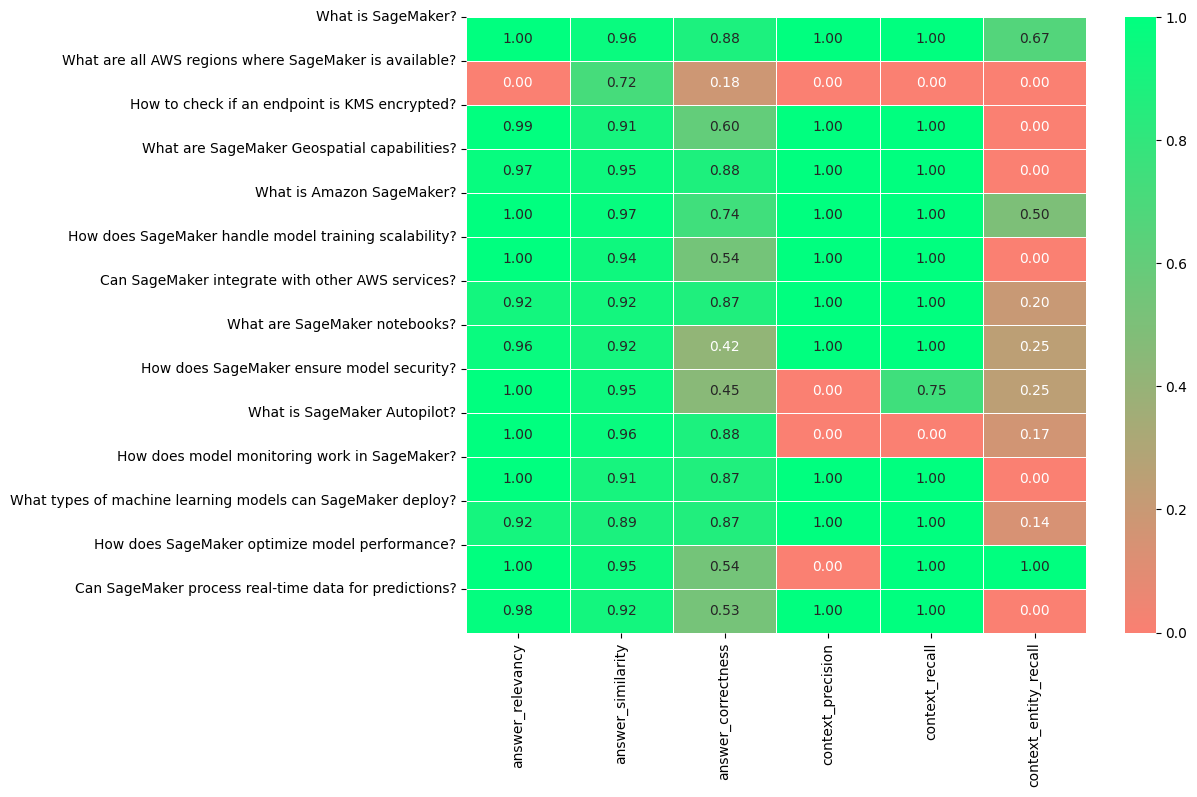

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[[
    "answer_relevancy",
    "answer_similarity",
    "answer_correctness",
    "context_precision",
    "context_recall",
    "context_entity_recall"
]]

cmap = LinearSegmentedColormap.from_list('green_red', ['salmon', 'springgreen'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()

#### class test usages

In [29]:
from raga_analyzer_processor import RagaAnalizer

analyzer = RagaAnalizer(retriever, rag_chain)


In [30]:
analyzer.preprocess_documents(splits)
questions, answers, contexts = analyzer.infer_answers(questions)

In [31]:
dataset = analyzer.create_dataset(questions, answers, contexts, ground_truths)


passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating: 100%|██████████| 84/84 [00:20<00:00,  4.18it/s]


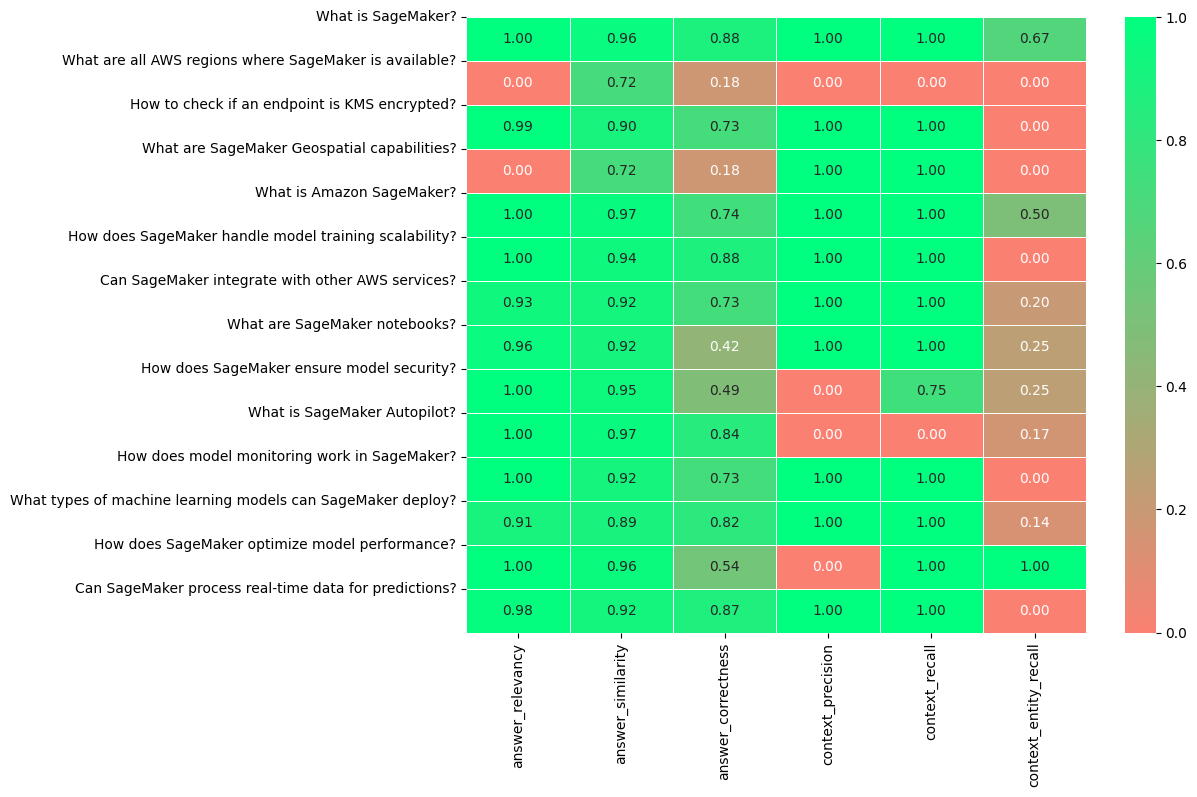

In [32]:
results = analyzer.evaluate_answers(dataset)
analyzer.plot_results(results)